In [1]:
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
import datetime
import pandas as pd
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import time
import glob
import os
from tqdm import tqdm

In [2]:
#parameters
chan_min = 0
chan_max = 1700
channel_number = chan_max -chan_min
low_cut1 = 1
hi_cut1 = 10
fs = 100
samples_per_file = 60*fs
b,a = butter(2,(low_cut1,hi_cut1),'bp',fs=fs)
number_of_template = 2

# Buiding Template

In [3]:
#first version, just one event
#download template oso earthquake data

# Ruta del archivo HDF5
rawdata_path = '/data/data5/Converted/whidbey_2022-05-17_08-07-00_UTC_014622.h5'

# Abrir el archivo HDF5
with h5py.File(rawdata_path, 'r') as rawdata_file:
    # Acceder a los datos que deseas
    rawdata = rawdata_file['Acquisition/Raw[0]/RawData']

    # Lee los datos en un arreglo NumPy
    this_template = np.array(rawdata[:, chan_min:chan_max])
    rawdata_file.close()
# Ahora puedes continuar con el procesamiento de los datos
b, a = butter(2, (low_cut1, hi_cut1), 'bp', fs=fs)
template_filt = filtfilt(b, a, this_template, axis=0)


# Recuerda cerrar el archivo HDF5 cuando hayas terminado si es necesario


In [4]:
pattern1 = "/data/data5/Converted/whidbey_2022-05-17_08*"
pattern2 = "/data/data5/Converted/whidbey_2022-05-18_*"

file_list = glob.glob(pattern1)#+glob.glob(pattern2)
#file_list.sort()
file_list.sort()
#file_list

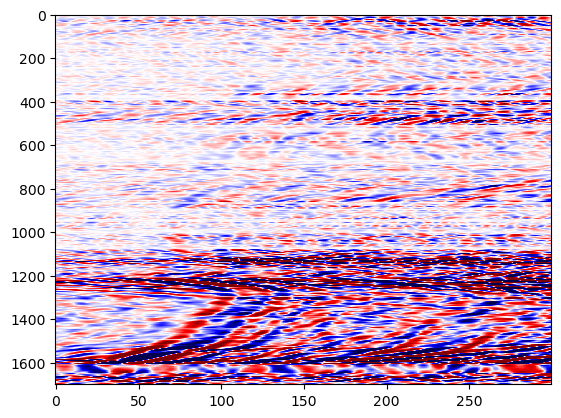

In [5]:
template = template_filt[5100:5400,:]
plt.imshow(template.T, cmap='seismic',aspect='auto',vmin=-1,vmax=1)
plt.show()


In [ ]:
#Second version making a nicer template


#file_list = glob.glob("/data/data5/Converted/whidbey_2022-05-17_08-07*")
#file_list
#download template oso earthquake data
template_file1_p = '/data/data5/Converted/whidbey_2022-05-17_08-07-00_UTC_014622.h5' #originaltemplate
##template_file1 = '/data/data5/Converted/whidbey_2022-05-17_08-07-00_UTC_014622.h5'
#template_file2 = '/data/data5/Converted/whidbey_2022-05-17_08-11-00_UTC_014626.h5'
template_file3_p = '/data/data5/Converted/whidbey_2022-05-17_08-13-00_UTC_014628.h5'
##
templates = []
templates_filt = []
#templates = [template_file1,template_file2,template_file3]
templates = [template_file1_p,template_file3_p]

##Opening and filtering two templates

for file in templates:
    with h5py.File(file,"r") as f:
         # read the data and extract timing information
        raw_data = np.array(f['Acquisition/Raw[0]/RawData'][:,chan_min:chan_max])
        #timestamps = np.array(f['Acquisition/Raw[0]/RawDataTime']) # time is microseconds since 1970-01-01
        data_filt = filtfilt(b,a,raw_data,axis=0)
        
        
        if data_filt.shape[0] > samples_per_file:
            data_filt = data_filt[:samples_per_file, :]
        elif data_filt.shape[0] < samples_per_file:
            data_filt = np.pad(data_filt, ((0, samples_per_file - data_filt.shape[0]), (0, 0)), mode='constant')
    templates_filt.append(data_filt)
    f.close()
    




In [6]:
#Run this in any case, it's doesnt matter, functions to correlate


def correlate(s1,s2,mode="same"):

    # throw an error of input sizes are inconsistent
    if s1.shape != s2.shape:
        raise ValueError("s1 and s2 must have the same size!")

    # get fft size
    sz = s1.shape[0]
    n_bits = 1+int(np.log2(2*sz-1))
    fft_sz = 2**n_bits

    # take FFT along time axis for both
    fft_s1 = np.fft.fft(s1, fft_sz, axis=0)
    fft_s2 = np.fft.fft(s2, fft_sz, axis=0)

    # take complex conjugate of second signal
    fft_s2_conj = np.conj(fft_s2)

    # multiply to get correlation function
    corr_fft = fft_s1*fft_s2_conj

    # take inverse fourier transform
    corr = np.fft.ifft(corr_fft, axis=0)

    # normalize using the magnitude of both input data
    norm1 = np.linalg.norm(s1,axis=0)
    norm2 = np.linalg.norm(s2,axis=0)
    norm_factor = norm1*norm2
    corr = np.vstack((corr[-(sz-1) :], corr[:sz]))
    norm_corr = np.real(corr) / norm_factor

    # return desired part of correlation function
    if mode == "full":
        pass
    elif mode == "same":
        norm_corr = norm_corr[int(sz/2):-int(sz/2)+1]
    return norm_corr


def window_and_correlate(template,data):

    # define container
    all_corr = []

    # get some helpful values
    window_length = template.shape[0]
    num_windows = int(data.shape[0]/window_length)

    # iterate through time windows
    for i in range(num_windows):

        # pull out a time window of data
        start_index = i*window_length
        end_index = start_index + window_length
        window = data[start_index:end_index,:]

        # call cross correlation function
        corr = correlate(template,window)

        # save value
        all_corr.append(corr)

    # reshape output
    all_corr = np.stack(all_corr)

    return all_corr
#corrs =  []
#corrs = (window_and_correlate(template,template_filt))

In [ ]:
#Calculating cross-correlation for both templates

cross_correlation_1_2 = correlate(templates_filt[0],templates_filt[1])
#cross_correlation_1_3 = correlate(templates_filt[0],templates_filt[2])
#cross_correlation_2_3 = correlate(templates_filt[1],templates_filt[2])

#plt.plot(cross_correlation_2_3)
#plt.show()


#Calculating time displacement

shift_1_2 = np.argmax(cross_correlation_1_2) - (len(templates_filt[0]) - 1)
#shift_1_3 = np.argmax(cross_correlation_1_3) - (len(templates_filt[1]) - 1)
#shift_2_3 = np.argmax(cross_correlation_2_3) - (len(templates_filt[2]) - 1)

#alignide them a plot it to see if it works!

aligned_data1 = np.roll(templates_filt[0], -shift_1_2)
aligned_data2 = templates_filt[1]  # No es necesario desplazar data2, ya que data1 se alineó con data2
#aligned_data3 = np.roll(templates_filt[2], -shift_2_3)

##plt.figure(figsize=(10, 6))  

##plt.plot(aligned_data1, label='Datos 1')
##plt.plot(aligned_data2, label='Datos 2 (Alineados)')
#plt.plot(aligned_data3, label='Datos 3 (Alineados)')
##plt.grid()
##plt.show()


In [ ]:
#Aligned and stacking  templates


#templates_alig = [aligned_data1, aligned_data2, aligned_data3]
templates_alig = [aligned_data1, aligned_data2]

#Calculting mean
#stacked_template = np.mean(templates_alig, axis=0)

final_template = np.sum(templates_alig, axis=0)


#choosing part of the template

##template = final_template[400:900,:]#we run the code with 400:900 channels
plt.imshow(final_template.T, cmap='seismic',aspect='auto',vmin=-1,vmax=1)
plt.show()
##plt.title('template to correlate with the data')
##plt.grid()
##plt.show()

In [ ]:
templates_final = final_template[500:900,:]
plt.imshow(templates_final.T, cmap='seismic',aspect='auto',vmin=-1,vmax=1)
plt.show()

In [ ]:
##plt.imshow(templates_filt,cmap='seismic',aspect='auto')
##plt.title('template to correlate with the data')
##plt.grid()
##plt.show()

In [ ]:
#testing with another earthquake from oso (magnitude 1.28)
#uw61855822	2022-07-22 12:51:02.070	4 km NE of Oso, Washington	48.300333	-121.885167	5.55	1
#file_list = glob.glob("/data/data5/Converted/whidbey_2022-07-22_12-51*h5")
#file_list = glob.glob("/data/data5/Converted/whidbey_2022-07-23_14-58*h5")#it should not have any earthquake here
#file_list


In [ ]:
#data_file = h5py.File('/data/data5/Converted/whidbey_2022-07-23_14-58-00_UTC_013862.h5','r')
#this_data = np.array(data_file['Acquisition/Raw[0]/RawData'][:,chan_min:chan_max])
#this_time = np.array(data_file['Acquisition/Raw[0]/RawDataTime'])
#attrs =     dict(data_file['Acquisition'].attrs)
#data_file.close()

In [ ]:

# list


#plt.imshow(corrs[10, :, :].T, cmap='gray', aspect='auto', vmin=-1.0, vmax=1.0)

# Cross-correlation-plot
#plt.colorbar()
#plt.title('Cross-correlation')
#plt.xlabel("time-#samples")
#plt.show()


In [ ]:
#corrs2 = corrs.reshape((samples_per_file,channel_number))
#plt.imshow(corrs2, aspect= 'auto')
#plt.show()
#channel_number = chan_max -chan_min

#corrs3 = np.sum(corrs2,axis=1)/channel_number
#corrs3
#plt.plot(corrs3)
#plt.show()

In [ ]:
#Creating directories for each experiments


#file_list = glob.glob("/data/data5/Converted/whidbey_2022-05-17_08*")
#file_list.sort()


npycorrs = "npycorrs"
daystart = file_list[0]
dayend = file_list[-1]

parts = daystart.split('/')
parts2 =  dayend.split('/')

if len(parts) >= 5:
    # Obtiene la quinta parte y la asigna a daystart
    daystart = parts[4]
    dayend = parts2[4]

daystart_f = daystart.replace(".h5", "")
dayend_f = dayend.replace(".h5", "")



folder_output  = f"{npycorrs}_{number_of_template}_{chan_min}_{chan_max}_{daystart_f}_{dayend_f}"

##

# Crea el directorio
if not os.path.exists(folder_output):
    os.mkdir(folder_output)
    print(f"Directorio '{folder_output}' creado con éxito.")
else:
    print(f"El directorio '{folder_output}' ya existe.")


In [7]:
# Registra el tiempo de inicio
inicio_tiempo = time.perf_counter()



datetimestotal = []

b,a = butter(2,(low_cut1,hi_cut1),'bp',fs=fs)
corrs3_list = []
all_timestamps = []

for i, file in tqdm(enumerate(file_list)):
    with h5py.File(file,"r") as f:
         # read the data and extract timing information
        raw_data = np.array(f['Acquisition/Raw[0]/RawData'][:,chan_min:chan_max])
        timestamps = np.array(f['Acquisition/Raw[0]/RawDataTime']) # time is microseconds since 1970-01-01
        data_filt = filtfilt(b,a,raw_data,axis=0)
        
        #all_timestamps.extend(timestamps)
        # check length of files
        win_start = i*samples_per_file
        win_end = (i+1)*samples_per_file
        
        #datetimes = [datetime.datetime.fromtimestamp(t/1000000) for t in timestamps]#seattle time
        #datetimestotal.append(datetimes)
      
        for i, file in enumerate(file_list):
        # Resto del código
            datetimes = [datetime.datetime.fromtimestamp(t/1000000) for t in timestamps]  # seattle time
            datetimestotal.extend(datetimes)
        
        
        
        if data_filt.shape[0] > samples_per_file:
            data_filt = data_filt[:samples_per_file, :]
        elif data_filt.shape[0] < samples_per_file:
            data_filt = np.pad(data_filt, ((0, samples_per_file - data_filt.shape[0]), (0, 0)), mode='constant')
        f.close()
        # Calculate correlations
        corrs = window_and_correlate(template, data_filt)
        corrs2 = corrs.reshape((samples_per_file, channel_number))
        corrs3 = np.sum(corrs2, axis=1) / channel_number
        corrs3_list.append(corrs3)
        
        # Save all the corrs3 arrays into separate .npy files

        
        #output_folder = folder_output   
        # Guardar todos los corrs3 arrays en archivos .npy separados
        #output_folder = "./test3"
        
        #for i, corrs3 in enumerate(corrs3_list):
        #    outfile_name = os.path.join(output_folder, f'corrs3_{i}.npy')
        #    np.save(outfile_name, corrs3)
    
        # Guardar todos los timestamps en un solo archivo .npy
        #for i, timestamps in enumerate(all_timestamps):
        #    timestamps_file = os.path.join(output_folder, f'timestamps_{i}.npy')
        #    np.save(timestamps_file, timestamps)



                            


# Registra el tiempo de finalización
fin_tiempo = time.perf_counter()

# Calcula el tiempo de ejecución
finaltime = fin_tiempo - inicio_tiempo

print(f"code took {finaltime} seconds.")

                            

60it [02:31,  2.53s/it]

code took 151.7902601584792 seconds.


In [22]:
import time
import h5py
import numpy as np
from scipy.signal import butter, filtfilt
import datetime
from tqdm import tqdm

# Resto de las variables y configuraciones

datetimestotal = []
corrs3_list = []

inicio_tiempo = time.perf_counter()

for i, file in tqdm(enumerate(file_list)):
    with h5py.File(file, "r") as f:
        raw_data = np.array(f['Acquisition/Raw[0]/RawData'][:, chan_min:chan_max])
        timestamps = np.array(f['Acquisition/Raw[0]/RawDataTime'])
        data_filt = filtfilt(b, a, raw_data, axis=0)
        
        win_start = i * samples_per_file
        win_end = (i + 1) * samples_per_file

        datetimes = [datetime.datetime.fromtimestamp(t/1000000) for t in timestamps]  # Seattle time
        datetimestotal.extend(datetimes)

        if data_filt.shape[0] > samples_per_file:
            data_filt = data_filt[:samples_per_file, :]
        elif data_filt.shape[0] < samples_per_file:
            data_filt = np.pad(data_filt, ((0, samples_per_file - data_filt.shape[0]), (0, 0)), mode='constant')
        f.close()

        corrs = window_and_correlate(template, data_filt)
        corrs2 = corrs.reshape((samples_per_file, channel_number))
        corrs3 = np.sum(corrs2, axis=1) / channel_number
        corrs3_list.append(corrs3)

fin_tiempo = time.perf_counter()
finaltime = fin_tiempo - inicio_tiempo

print(f"code took {finaltime} seconds.")


60it [02:22,  2.37s/it]

code took 142.02754086442292 seconds.


In [ ]:
#fig = plt.figure(figsize=(20, 5))  # Increased figure size

#for i in range(len(file_list)):
#    archivo_npy_a_abrir = f"./npycorrs_2_0_1700_whidbey_2022-05-17_00-00-00_UTC_014141_whidbey_2022-05-17_23-59-00_UTC_015566/corrs3_{i}.npy"

#    # load files with load
#    datos = np.load(archivo_npy_a_abrir)
#    t0 = i * 60
#    t = np.linspace(t0, t0 + 60, 6000)

#    # Plot with custom line styles and colors
#    plt.plot((t / 3600), datos, linestyle='-', color='k', linewidth=1)

#plt.xlabel("Time (min)", fontsize=18)  # Increased fontsize
#plt.ylabel("Cross Correlation Value", fontsize=18)  # Increased fontsize
#plt.title('Swarm Oso, 1 template (1000-1710 channels)-using 3 sec of templates -2days data', fontsize=20)  # Increased fontsize

#plt.xlim((480,600))
#plt.xlim((8,10))
#plt.ylim((0, 0.07))
#plt.ylim((0, 0.05))

#plt.grid(True)
#plt.tick_params(axis='x', labelsize=15)
#plt.savefig('prelimfigure_zoom.png', dpi=300, bbox_inches='tight')
#plt.show()









In [ ]:
#import csv

# Lista donde almacenaremos los valores de la columna "Time UTC"
#tiempos_utc = []

# Nombre del archivo CSV
#nombre_archivo_csv = 'pnsn_event_export_20231005.csv'

# Abrir el archivo CSV y leer sus contenidos
#with open(nombre_archivo_csv, 'r') as archivo_csv:
#    lector_csv = csv.DictReader(archivo_csv)  # Utilizamos DictReader para acceder a las columnas por nombre
    
    # Iterar a través de las filas del archivo CSV
#    for fila in lector_csv:
        # Acceder al valor de la columna "Time UTC" y añadirlo a la lista
 #       tiempo_utc = fila['Time UTC']
 #       tiempos_utc.append(tiempo_utc)

# Ahora, tiempos_utc contiene todos los valores de la columna "Time UTC" del archivo CSV
# Puedes usar esta lista como desees
#print(tiempos_utc)


In [19]:
from datetime import datetime

fechas_y_horas_str = [
    '2022/05/17 08:42:07',
    '2022/05/17 08:39:41',
    '2022/05/17 08:35:51',
    '2022/05/17 08:30:41',
    '2022/05/17 08:13:23',
    '2022/05/17 08:11:02',
    '2022/05/17 08:07:34'
]

# Crear una lista para almacenar las horas en formato datetime
horas_datetime = []

# Convertir las fechas y horas en objetos datetime
for fecha_hora_str in fechas_y_horas_str:
    fecha_hora_obj = datetime.strptime(fecha_hora_str, "%Y/%m/%d %H:%M:%S")
    horas_datetime.append(fecha_hora_obj)

# Ahora, horas_datetime contiene las horas en formato datetime
print(horas_datetime)


[datetime.datetime(2022, 5, 17, 8, 42, 7), datetime.datetime(2022, 5, 17, 8, 39, 41), datetime.datetime(2022, 5, 17, 8, 35, 51), datetime.datetime(2022, 5, 17, 8, 30, 41), datetime.datetime(2022, 5, 17, 8, 13, 23), datetime.datetime(2022, 5, 17, 8, 11, 2), datetime.datetime(2022, 5, 17, 8, 7, 34)]


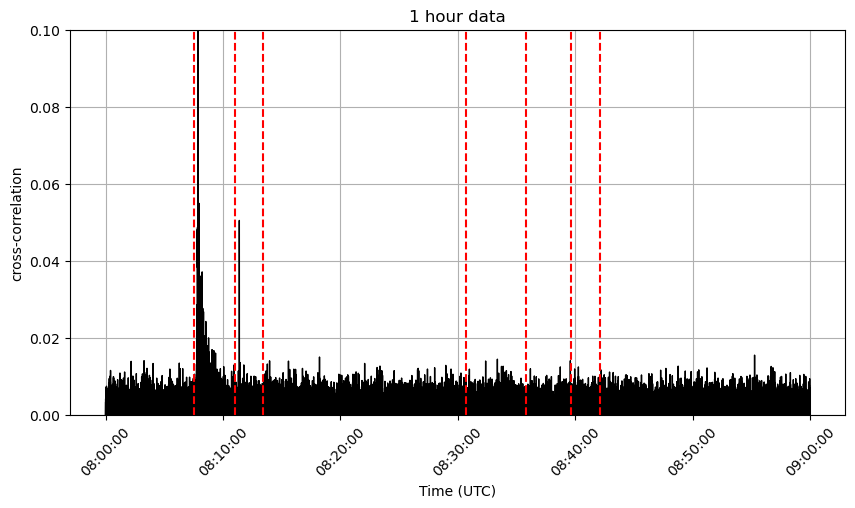

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pytz
import datetime
import csv
import matplotlib.dates as mdates

# Supongamos que tienes dos listas: corrs3_list y datetimestotal

# Crear una lista que contenga todos los puntos de correlación
corrs_all = []
for i, corrs3 in enumerate(corrs3_list):
    corrs_all.extend(corrs3)


corrs_all = np.array(corrs_all)
datetimes_all = np.array(datetimestotal)

# Supongamos que tienes un arreglo datetimes_array con 360,000 elementos
# y un arreglo corrs3_list que contiene 60 arreglos de 6000 puntos cada uno

# Definir la zona horaria original (supongamos que es Seattle)
zona_horaria_original = pytz.timezone('America/Los_Angeles')

# Convertir datetimes_array a UTC time
utc_timezone = pytz.timezone('UTC')
dates_times_utc = [date_time_pacific.astimezone(utc_timezone) for date_time_pacific in datetimes_all]


# Unir todos los arreglos de correlaciones en uno solo
correlaciones_totales = np.concatenate(corrs3_list)

# Obtener la lista de horas desde el ejemplo anterior
 # Reemplaza esto con tus horas reales

# Graficar correlaciones en función del tiempo en UTC
plt.figure(figsize=(10, 5))
plt.plot(dates_times_utc, correlaciones_totales, linestyle='-', color='k', linewidth=1)
plt.ylim((0, 0.1))
plt.xlabel("Time (UTC)")
plt.ylabel("cross-correlation")
plt.title("1 hour data")

plt.grid(True)

# Personalizar los marcadores del eje x
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x en 45 grados
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))  # Formato de fecha y hora

# Agregar líneas verticales en cada elemento de la lista horas_datetime
for hour_datetime in horas_datetime:
    plt.axvline(x=hour_datetime, color='r', linestyle='--')

plt.show()


ValueError: x and y must have same first dimension, but have shapes (0,) and (150000,)

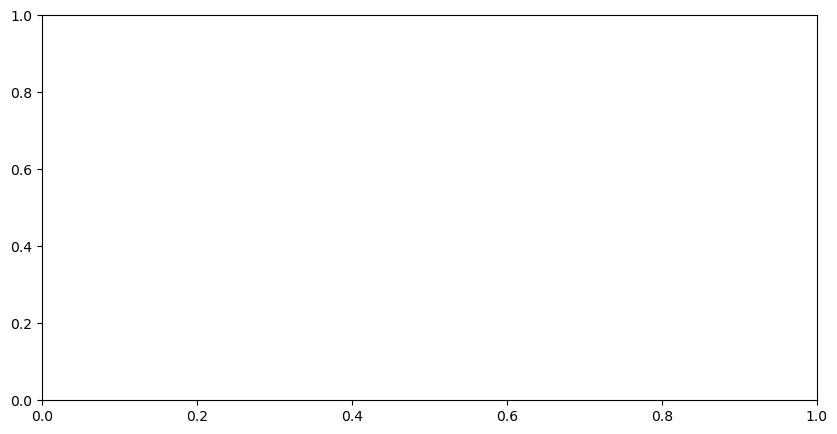

In [15]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pytz
import datetime
import os
import glob


carpeta_correlaciones = f"./test"


corrs3_list = []


files_data = os.path.join(carpeta_correlaciones, 'corrs3*.npy')
files_time = os.path.join(carpeta_correlaciones, 'datetimes*.npy')


filescorrs3 = glob.glob(files_data)
filesdatetime = glob.glob(files_time)


for archivo in filescorrs3:
    # Cargar los datos de correlación desde el archivo .npy
    correlaciones = np.load(archivo,allow_pickle=True)
    corrs3_list.append(correlaciones)   
    
datetimestotal = []
for archivo in filesdatetime:
    # Cargar los datos de correlación desde el archivo .npy
    datetimess = np.load(archivo,allow_pickle=True)
    datetimestotal.append(datetimess)
            

# Crear una lista correspondiente de fechas y horas datetime
#datetimes_all = []
#for i in range(len(datetimestotal)):
#    for j in range(6000):
#        datetimes_all.append(datetimestotal[i][0] + datetime.timedelta(microseconds=j * 1000000))

# Convertir las listas en arrays numpy
corrs_all = np.array(corrs3_list)
datetimes_all = np.array(datetimestotal)

# Supongamos que tienes un arreglo datetimes_array con 360,000 elementos
# y un arreglo corrs3_list que contiene 60 arreglos de 6000 puntos cada uno

# Definir la zona horaria original (supongamos que es Seattle)
zona_horaria_original = pytz.timezone('America/Los_Angeles')

# Convertir datetimes_array a UTC time
datetimes_utc = [zona_horaria_original.localize(dt).astimezone(pytz.utc) for dt in datetimes_all]

# Unir todos los arreglos de correlaciones en uno solo
correlaciones_totales = np.concatenate(corrs3_list)

# Obtener la lista de horas desde el ejemplo anterior
 # Reemplaza esto con tus horas reales

# Graficar correlaciones en función del tiempo en UTC
plt.figure(figsize=(10, 5))
plt.plot(datetimes_all, correlaciones_totales, linestyle='-', color='k', linewidth=1)
plt.ylim((0, 0.2))
plt.xlabel("Time (UTC)")
plt.ylabel("cross-correlation")
plt.title("1 hour data")

plt.grid(True)

# Personalizar los marcadores del eje x
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x en 45 grados
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))  # Formato de fecha y hora

# Agregar líneas verticales en cada elemento de la lista horas_datetime
#for hour_datetime in horas_datetime:
#    plt.axvline(x=hour_datetime, color='r', linestyle='--')

plt.show()


In [21]:
datetimestotal

[]

In [24]:
len(datetimestotal)

360000

In [30]:
datetimes_all = np.array(datetimestotal)

In [31]:
len(datetimes_all)


360000